In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os



# Function to load images and masks
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    for image_file in os.listdir(image_dir):
        image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, image_file), target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        images.append(image)

        mask_file = image_file.replace(".jpg", ".png")  # assuming mask files have the same name as images
        mask = tf.keras.preprocessing.image.load_img(os.path.join(mask_dir, mask_file), color_mode='grayscale', target_size=(128, 128))
        mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0
        masks.append(mask)
        
    return np.array(images), np.array(masks)

# Example usage
image_dir = 'Image'
mask_dir = 'Mask'
images, masks = load_images_and_masks(image_dir, mask_dir)

# Create binary labels for classification (flooded = 1, not flooded = 0)
classification_labels = (masks.sum(axis=(1, 2, 3)) > 0).astype(int)

# Split the dataset into training and validation sets
X_train, X_val, y_train_class, y_val_class, y_train_masks, y_val_masks = train_test_split(
    images, classification_labels, masks, test_size=0.2, random_state=42
)

# Build the model
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten for classification
    flat = Flatten()(x)
    dense = Dense(128, activation='relu')(flat)
    dense = Dropout(0.5)(dense)
    class_output = Dense(1, activation='sigmoid', name='classification')(dense)
    
    # Segmentation output (decoder)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='segmentation')(x)
    
    # Model
    model = Model(inputs=inputs, outputs=[class_output, mask_output])
    
    # Custom IoU metric for segmentation
    def iou_metric(y_true, y_pred):
        y_true = tf.cast(y_true > 0.5, tf.float32)
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
        return tf.reduce_mean(intersection / (union + tf.keras.backend.epsilon()))

    # Compile model
    model.compile(
        optimizer='adam',
        loss={'classification': 'binary_crossentropy', 'segmentation': 'binary_crossentropy'},
        metrics={'classification': 'accuracy', 'segmentation': iou_metric}
    )
    
    return model

# Build the model
model = build_model(input_shape=(128, 128, 3))
model.summary()

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,388,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,464 │ up_sampling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │        129 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segmentation        │ (None, 128, 128,  │         33 │ up_sampling2d_1[… │
│ (Conv2D)            │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,463,682 (32.29 MB)

 Trainable params: 8,463,682 (32.29 MB)

 Non-trainable params: 0 (0.00 B)

AttributeError: 'NumpyArrayIterator' object has no attribute 'next'

In [7]:
def generator(X_data, y_class, y_masks, batch_size):
    datagen_flow = datagen.flow(X_data, batch_size=batch_size, shuffle=False)
    
    while True:
        # Get a batch of images
        batch_images = next(datagen_flow)  # Use next() instead of .next()

        # Get the actual batch size (could be less than batch_size at the end of the data)
        current_batch_size = batch_images.shape[0]

        # Slice the corresponding labels for classification and segmentation
        batch_labels_class = y_class[:current_batch_size]  # Slice labels based on current batch size
        batch_labels_masks = y_masks[:current_batch_size]  # Slice masks based on current batch size

        # Yield the images and the corresponding labels
        yield batch_images, {'classification': batch_labels_class, 'segmentation': batch_labels_masks}


In [8]:
#Train the model
history = model.fit(
    generator(X_train, y_train_class, y_train_masks, batch_size=16),
    steps_per_epoch=len(X_train) // 16,
    validation_data=(X_val, {'classification': y_val_class, 'segmentation': y_val_masks}),
    epochs=20
)

# Evaluate the model




Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - classification_accuracy: 0.7923 - loss: 0.8669 - segmentation_iou_metric: 0.0888 - val_classification_accuracy: 1.0000 - val_loss: 0.6862 - val_segmentation_iou_metric: 0.0000e+00
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - classification_accuracy: 1.0000 - loss: 0.6768 - segmentation_iou_metric: 6.9259e-04 - val_classification_accuracy: 1.0000 - val_loss: 0.6824 - val_segmentation_iou_metric: 0.0326
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - classification_accuracy: 1.0000 - loss: 0.6749 - segmentation_iou_metric: 0.0326 - val_classification_accuracy: 1.0000 - val_loss: 0.6774 - val_segmentation_iou_metric: 0.0464
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - classification_accuracy: 1.0000 - loss: 0.6723 - segmentation_iou_metric: 0.0545 - val_classification_accuracy: 1.0000 - val_loss: 0.6741 - val_segmentation_iou_metric: 0.0532
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - classification_accurac

ValueError: not enough values to unpack (expected 5, got 3)

In [12]:
loss, class_loss, seg_loss, class_acc, mean_iou = model.evaluate(
    X_val, {'classification': y_val_class, 'segmentation': y_val_masks}
)
print(f'Classification Accuracy: {class_acc}')
print(f'Mean IOU: {mean_iou}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - classification_accuracy: 1.0000 - loss: 0.6609 - segmentation_iou_metric: 0.1048


ValueError: not enough values to unpack (expected 5, got 3)

In [13]:
# Evaluate the model
eval_output = model.evaluate(X_val, {'classification': y_val_class, 'segmentation': y_val_masks})

# Check the length of eval_output to adjust unpacking
print(f'Evaluation output: {eval_output}')

# Adjust unpacking based on the number of returned values
if len(eval_output) == 3:
    loss, class_loss, seg_loss = eval_output
    print(f'Classification Loss: {class_loss}')
    print(f'Segmentation Loss: {seg_loss}')
elif len(eval_output) == 5:
    loss, class_loss, seg_loss, class_acc, mean_iou = eval_output
    print(f'Classification Accuracy: {class_acc}')
    print(f'Mean IOU: {mean_iou}')
else:
    print(f'Unexpected number of values returned: {len(eval_output)}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - classification_accuracy: 1.0000 - loss: 0.6609 - segmentation_iou_metric: 0.1048
Evaluation output: [0.6608848571777344, 1.0, 0.10548096150159836]
Classification Loss: 1.0
Segmentation Loss: 0.10548096150159836


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Flooded: [[ True]]


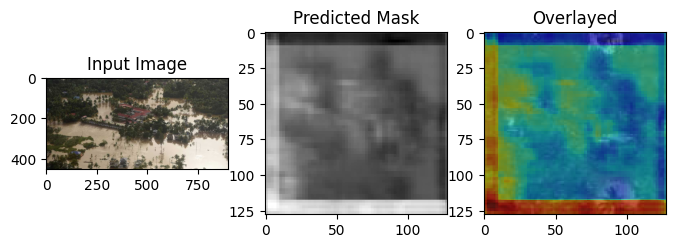

In [22]:
image_path = 'p1.jpg'
def predict_image(image_path, model):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    class_pred, mask_pred = model.predict(image)
    return class_pred, mask_pred

# Example usage
class_pred, mask_pred = predict_image(image_path, model)
print(f'Flooded: {class_pred > 0.5}')

# Plot the results
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(tf.keras.preprocessing.image.load_img(image_path))

plt.subplot(1, 3, 2)
plt.title('Predicted Mask')
plt.imshow(mask_pred[0, :, :, 0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Overlayed')
plt.imshow(tf.keras.preprocessing.image.load_img(image_path))
plt.imshow(mask_pred[0, :, :, 0], cmap='jet', alpha=0.5)

plt.show()

In [21]:
# Save the entire model
model.save('segmentation.h5')
